In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


# Импорт библиотек

In [ ]:
!pip install sentence_transformers -q
!pip install scikit-learn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import re
import os
import pandas as pd
import string
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from copy import deepcopy
from collections import Counter
from pymystem3 import Mystem
from sklearn.manifold import TSNE
import random
import numpy as np
random.seed(1)
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, HDBSCAN, SpectralClustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Импорт данных

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c vacanciesru
!unzip vacanciesru.zip

In [ ]:
datasets = {}
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        file_reg = re.match(r"vacancies_[0-9]{4}.csv", filename)
        year_reg = re.search(r"[0-9]{4}", filename)
        if file_reg:
            datasets[int(year_reg.group())] = os.path.join(dirname, filename)

In [ ]:
def get_df(year, columns=[]):

  if len(columns) == 0:
    return pd.read_csv(datasets[year])
  else:
    return pd.read_csv(datasets[year], usecols=columns)

In [ ]:
use_data = get_df(2020, ["description", "key_skills", "name"]).sample(100000, random_state=1)

In [ ]:
print(use_data.info())
use_data.sample(10)

Несколько примеров:

In [ ]:
print(use_data[use_data.key_skills.notna()].sample(1).description.values)
print(use_data[use_data.key_skills.notna()].sample(1).key_skills.values)
print(use_data[use_data.key_skills.notna()].sample(1).name.values)

In [ ]:
print(use_data[use_data.key_skills.notna()].sample(1).description.values)
print(use_data[use_data.key_skills.notna()].sample(1).key_skills.values)
print(use_data[use_data.key_skills.notna()].sample(1).name.values)

# Препроцессинг текста

Нужно распарсить первую и вторую колонки, привести текст к единообразному виду

In [ ]:
def preprocessing(text):

  text = ' ' + text + ' '
  text = BeautifulSoup(text, 'html.parser').get_text()
  text = re.sub(r"[{}]".format(string.punctuation + '—“”·«»•–±') + '|\n|\t', ' ', text)
  while re.findall(r'\shttp\S*\s|\swww\S*\s', text):
    text = re.sub(r'\shttp\S*\s|\swww\S*\s', ' ', text)
  text = re.sub('\d', '', text)
  text = re.sub('\s+', ' ', text)
  text = text.lower()
  text = text.strip()

  return text

In [ ]:
for text in use_data.description.sample(10):
  print(preprocessing(text))

о нас anyclass tv платформа онлайн образования по нашим онлайн курсам ежедневно занимаются более клиентов в наших instagram аккаунтах более млн подписчиков мы лидеры рынка по продажам онлайн курсов в этой социальной сети сми об anyclass anyclass tv vcanyclass tv cossaanyclass tv rbcanyclass tv kommersant кого ищем менеджера по связям с общественностью который будет отвечать за имидж компании и позиционирование на рынке edtech профиль идеального кандидата опыт построения стратегии продвижения бренда в сми наличие базы лояльных средств массовой информации лидеров мнений и журналистов готовых к сотрудничеству интерес к сфере edtech понимание тенденций и технологий прекрасный опыт переговоров и умение добиваться самых выгодных условий какие задачи предстоит решать создание информационных поводов поиск и создание контента адаптация и распространение его в сми расширение партнерской базы наработка связей в отрасли edtech управление репутацией в интернете участие в edtech конференциях присутс

In [ ]:
for text in use_data.key_skills[use_data.key_skills.notna()].sample(10):
  print(preprocessing(text))

хорошее знание it рынка и it продуктов серверы схд сетевое оборудование
jquery javascript mysql css html php
javascript webgl
git javascript jquery mysql moodle системы дистанционного образования php
git atlassian jira английский язык работа в команде golang grpc
smm google analytics
tcp ip администрирование серверов windows mac os настройка сетевых подключений windows
английский язык пользователь пк письменный перевод
tcp ip торговый маркетинг бухгалтерский учет networking ms access
заключение договоров активные продажи bb продажи работа с возражениями сопровождение клиентов документальное сопровождение оценка потребностей клиентов


<ipython-input-11-bf5bd8019163>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [ ]:
for text in use_data.name.sample(10):
  print(preprocessing(text))

сервис менеджер менеджер по сервису
системный аналитик логистика
инженер конструктор
ведущий инженер программист
продавец консультант в салон каминов
менеджер проекта продюсер онлайн школа
системный аналитик сбербанк бизнес онлайн
начальник сектора системного администрирования г санкт петербург
content manager
инженер информационно аналитического отдела


<ipython-input-11-bf5bd8019163>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [ ]:
def get_preprocessed_data(df):

  prep_df = pd.DataFrame(columns=df.columns)
  for column in df.columns:
    prep_df[column] = df[column].apply(lambda text: preprocessing(text) if isinstance(text, str) else '')

  return prep_df

In [ ]:
prep_data = get_preprocessed_data(use_data)

<ipython-input-11-bf5bd8019163>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


In [ ]:
prep_data

,description,key_skills,name
398973,ростелеком контакт центр в г уфа предлагает ва...,дистанционное обучение грамотная речь деловое ...,удалённый специалист технической поддержки
204284,about the job you will be a part of wholesale ...,ms sql analytical skills databases process mod...,database developer sql
340258,обязанности разработка доработка веб сайтов на...,,web разработчик bitrix
347136,обязанности активный поиск it специалистов раз...,,hr it recruiter
505097,компания аспро команда профессиональных разраб...,bb маркетинг bc маркетинг продвижение в социал...,ассистент маркетолога
...,...,...,...
418292,мы core технологичный edtech стартап мы молоды...,фронтенд javascript git react js redux функцио...,frontend разработчик react
509340,каждый день миллионы пользователей находят отв...,работа в команде грамотная речь разработка тех...,специалист в службу поддержки геосервисов
453398,офис продаж визитная карточка нашего бизнеса и...,,продавец консультант
25686,обязанности доработка программных продуктов на...,с предприятие с зарплата и управление персонал...,программист c


Для случаев, когда ключевые скилы отсутствуют, можно попытаться найти их в описании вакансии. Часто ключевые скилы описывают технологии/фреймворки, с которыми должен уметь работать кандидат, а сами они в большинстве случаях называются английскими словами. Именно их можно представить ключевыми скиллами. Кроме случаев, когда все описание представляет из себя английский текст

In [ ]:
use_data.loc[204284].description

'<p><strong>ABOUT THE JOB</strong></p> <p>You will be a part of Wholesale organisation - an important contributor to the customer fulfillment chain ensuring timely availability of goods in IKEA stores and omnichannel sources in Russia for the customer at the lowest prices. This function is responsible for the full scope of actions needed to comply with the demands legislation in Russian Federation related to import of goods as well as selling the goods to retailer.</p> <p><em>You will:</em></p> <ul> <li>Be responsible for database development and optimization;</li> <li>Make business procedures description;</li> <li>Participate in processes efficiency increase and control;</li> <li>Providing statistics for the department;</li> <li>Act as a project leader within the area of responsibility;</li> <li>Contact with developers of IT systems;</li> <li>Large data analysis.</li> </ul> <p><strong>WHAT YOU&#39;LL NEED TO HAVE</strong></p> <ul> <li>Experience with business analytical tools;</li> <l

In [ ]:
prep_data.loc[204284].description

'about the job you will be a part of wholesale organisation an important contributor to the customer fulfillment chain ensuring timely availability of goods in ikea stores and omnichannel sources in russia for the customer at the lowest prices this function is responsible for the full scope of actions needed to comply with the demands legislation in russian federation related to import of goods as well as selling the goods to retailer you will be responsible for database development and optimization make business procedures description participate in processes efficiency increase and control providing statistics for the department act as a project leader within the area of responsibility contact with developers of it systems large data analysis what you ll need to have experience with business analytical tools proven analytical skills and ability to understand different complex scenarios good knowledge of ms sql and sql processes documentation understanding responsibility organized nat

In [ ]:
from copy import deepcopy
from collections import Counter
import numpy as np

def find_key_skills(df):

  key_skills_list = []
  for key_skills in df[df.key_skills != ''].key_skills:
    for key_skill in key_skills.split():
      key_skills_list += [key_skill]

  key_skills_dict = Counter(key_skills_list)

  augumented_df = deepcopy(df)
  for index in df[df.key_skills == ''].index:
    if re.findall(r'[а-яА-ЯёЁ]', df.loc[index].description):
      text = df.loc[index].description
      key_skills = [word for word in text.split() if not re.findall(r'[а-яА-ЯёЁ]', word)
                                                     and key_skills_dict.get(word) is not None]
      augumented_df.at[index, 'key_skills'] = ' '.join([key_skill for key_skill_num, key_skill in enumerate(key_skills)
                                                        if key_skills.index(key_skill) == key_skill_num])

  return augumented_df

In [ ]:
augumented_data = find_key_skills(prep_data)

In [ ]:
augumented_data

,description,key_skills,name
398973,ростелеком контакт центр в г уфа предлагает ва...,дистанционное обучение грамотная речь деловое ...,удалённый специалист технической поддержки
204284,about the job you will be a part of wholesale ...,ms sql analytical skills databases process mod...,database developer sql
340258,обязанности разработка доработка веб сайтов на...,cms api d php css js jquery git webpack,web разработчик bitrix
347136,обязанности активный поиск it специалистов раз...,it skype pre intermediate,hr it recruiter
505097,компания аспро команда профессиональных разраб...,bb маркетинг bc маркетинг продвижение в социал...,ассистент маркетолога
...,...,...,...
418292,мы core технологичный edtech стартап мы молоды...,фронтенд javascript git react js redux функцио...,frontend разработчик react
509340,каждый день миллионы пользователей находят отв...,работа в команде грамотная речь разработка тех...,специалист в службу поддержки геосервисов
453398,офис продаж визитная карточка нашего бизнеса и...,,продавец консультант
25686,обязанности доработка программных продуктов на...,с предприятие с зарплата и управление персонал...,программист c


Что осталось после обогащения данных:

In [ ]:
len(augumented_data[augumented_data.key_skills == ''])

7263

In [ ]:
augumented_data[augumented_data.key_skills == ''].sample(5)

,description,key_skills,name
160100,в некоторых проектах яндексу помогают компании...,,асессор психология и психиатрия
578354,если у вас мало опыта или возможно вы ищите се...,,it специалист монтаж скс
579917,мтс крупнейший телеком бренд в россии и снг ци...,,специалист по продаже и установке спутникового тв
308983,требуется монтажник телекоммуникационных систе...,,монтажник слаботочных систем
83356,на работу вахтовым методом в тульскую свердлов...,,оператор наладчик станков с чпу


Что получилось обогатить:

In [ ]:
augumented_data[(prep_data.key_skills == '') & (augumented_data.key_skills != '')]

,description,key_skills,name
340258,обязанности разработка доработка веб сайтов на...,cms api d php css js jquery git webpack,web разработчик bitrix
347136,обязанности активный поиск it специалистов раз...,it skype pre intermediate,hr it recruiter
117735,привет мы azur games международный разработчик...,azur games free to play vfx artist robot tps v...,vfx artist robot warfare jurassic monster world
271801,обязанности поддержка и развитие существующего...,stl gui qt xml linux it,инженер программист с junior c developer
582657,привет я артур кузяков основатель компании dri...,scrum cto p s \ ps,chief technical officer в scrum команду в москву
...,...,...,...
297575,разрабатываем plesk панель управления серверам...,plesk r d php js c go python java amazon web s...,qa engineer core team
212396,ищешь работу в открытой рабочей среде готов к ...,online,оператор входящие звонки
144252,мтс крупнейший телеком бренд в россии и снг ци...,lte g ida kpi,бригадир группы эксплуатации сети и подключени...
392331,что мы предоставим работайте из любой точки ми...,rdp skype bitrix hard skills php framework mvc...,разработчик bitrix


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/augumented_data.pkl', 'wb') as file:
  pickle.dump(augumented_data, file)

# Предобработанные данные из файла

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/augumented_data.pkl', 'rb') as file:
  augumented_data = pickle.load(file)

# Подготовка к эмбеденгам

Для простоты соединим получившиеся данные в одну строку, и получим ее векторное представление разными способами.

In [ ]:
joined_data = pd.Series(index=augumented_data.index, name='sentence', dtype='object')
for index in augumented_data.index:
  joined_data.loc[index] = augumented_data.at[index, 'description'] + ' ' \
                           + augumented_data.at[index, 'key_skills'] + ' ' \
                           + augumented_data.at[index, 'name']

joined_data

398973    ростелеком контакт центр в г уфа предлагает ва...
204284    about the job you will be a part of wholesale ...
340258    обязанности разработка доработка веб сайтов на...
347136    обязанности активный поиск it специалистов раз...
505097    компания аспро команда профессиональных разраб...
                                ...                        
418292    мы core технологичный edtech стартап мы молоды...
509340    каждый день миллионы пользователей находят отв...
453398    офис продаж визитная карточка нашего бизнеса и...
25686     обязанности доработка программных продуктов на...
495855    ifellow ит компания нового поколения предлагаю...
Name: sentence, Length: 100000, dtype: object

<Axes: ylabel='Count'>

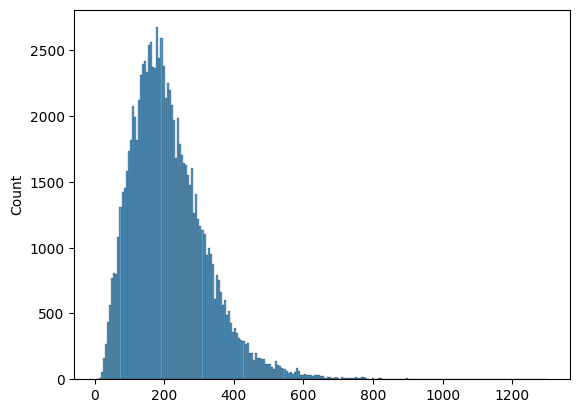

In [ ]:
sns.histplot([len(text.split(' ')) for text in joined_data])

Пример большого текста:

In [ ]:
joined_data.loc[246500]

'привет мы уверены что входная дверь в жизнь мечты это грамотное управление своим временем поэтому уже лет обучаем женщин тайм менеджменту онлайн более человек уже прошли у нас обучение и мы продолжаем набирать обороты сейчас у нас открыта позиция контент маркетолога который знает ильяхова не только по книжке пиши сокращай понимает что в основе качественного продукта лежит ценностное предложение любит писать креативить создавать творить все виды контента мечтает писать контент планы с учетом всех каналов коммуникации с клиентом и всех возможных типов контента понимает что маркетинг без аналитики как рик без морти не существует поэтому ga метрика или аналоги search console gtm optimize медиатор io analytics content insights parse ly chartbeat не новые слова которые приходиться гуглить а рабочие инструменты понимает что будущее за видео контентом поэтому умеет продвигать контент в youtube и на ты с метриками видео контента хочет применить свои знания на крутом продукте в команде с лучшим

# Эмбеденги с помощью трансформера

Поскольку мы имеем дело только русским и английским текстом, используем мультязычный трансформер с сокращенным словарем, и получим эмбеденги сразу для предложений с помощью sentence_transformers:

In [ ]:
emb_model = SentenceTransformer('d0rj/e5-small-en-ru')

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.23M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
print(emb_model.max_seq_length)

514


In [ ]:
emb_model.max_seq_length = 512

Поскольку длина некоторых текстов больше максимальной длины возможного эмбединга, отрежем с конца больших текстов 400 символов. Будем считать их отражением всего текста, потому что в них будет содержаться информация как из описаниея, так и из ключевых скиллов и названия вакансии

In [ ]:
cut_joined_data = joined_data.apply(lambda text: ' '.join(text.split()[-400:]) if len(text.split()) > 400 else text)

<Axes: ylabel='Count'>

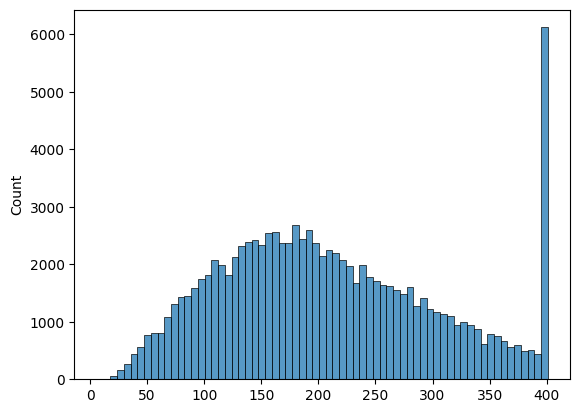

In [ ]:
sns.histplot([len(text.split(' ')) for text in cut_joined_data])

Для работы с этой моделью необходимо впереди каждой строки указывать "query:":

In [ ]:
cut_joined_data = cut_joined_data.apply(lambda text: 'query: ' + text)

Получим эмбединги:

In [ ]:
cut_joined_data

398973    query: ростелеком контакт центр в г уфа предла...
204284    query: about the job you will be a part of who...
340258    query: обязанности разработка доработка веб са...
347136    query: обязанности активный поиск it специалис...
505097    query: компания аспро команда профессиональных...
                                ...                        
418292    query: каждый человек может стать преподавател...
509340    query: каждый день миллионы пользователей нахо...
453398    query: офис продаж визитная карточка нашего би...
25686     query: обязанности доработка программных проду...
495855    query: ifellow ит компания нового поколения пр...
Name: sentence, Length: 100000, dtype: object

In [ ]:
sample_for_transformer = cut_joined_data.sample(10000, random_state=1)

In [ ]:
reidexed_sample_for_transformer = deepcopy(sample_for_transformer)
reidexed_sample_for_transformer.index = range(len(reidexed_sample_for_transformer))

In [ ]:
transformer_emb = emb_model.encode(reidexed_sample_for_transformer,
                                   show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/sample_transformer_emb.pkl', 'wb') as file:
  pickle.dump(transformer_emb, file)

# Эмбединги с помощью трансформера из файла

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/sample_transformer_emb.pkl', 'rb') as file:
  transformer_emb = pickle.load(file)

# Понижение размерности эмбедингов из трансформера

In [ ]:
sample_tsne = TSNE(random_state=1, perplexity=100, n_iter=500, metric="cosine")
sample_tsne_vis_transformer_emb = sample_tsne.fit_transform(transformer_emb)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/sample_tsne_vis_transformer_emb.pkl', 'wb') as file:
  pickle.dump(sample_tsne_vis_transformer_emb, file)

# Понижение размерности эмбедингов с помощью трансформера из файла

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/sample_tsne_vis_transformer_emb.pkl', 'rb') as file:
  sample_tsne_vis_transformer_emb = pickle.load(file)

# Визуализируем эмбединги из трансформера

<Axes: >

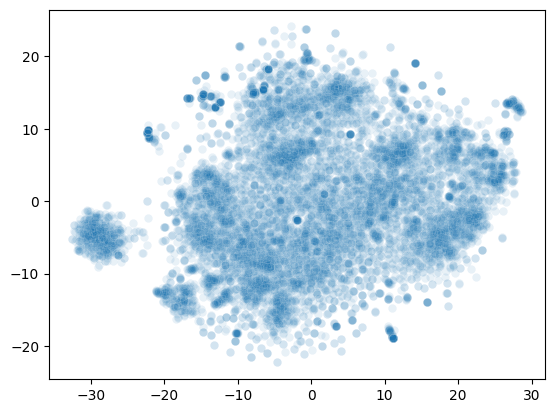

In [ ]:
sns.scatterplot(x=sample_tsne_vis_transformer_emb[:, 0],
                y=sample_tsne_vis_transformer_emb[:, 1],
                alpha=.1)

# Дополнительный препроцессинг с лемматизацией

Используем только вакансии на русском языке:

In [ ]:
ru_data = deepcopy(joined_data)
for index in joined_data.index:
  if not re.findall(r'[а-яА-ЯёЁ]', joined_data.loc[index]):
    ru_data = ru_data.drop(index=index)

ru_data

398973    ростелеком контакт центр в г уфа предлагает ва...
340258    обязанности разработка доработка веб сайтов на...
347136    обязанности активный поиск it специалистов раз...
505097    компания аспро команда профессиональных разраб...
66945     semrush это уникальный сервис для профессионал...
                                ...                        
418292    мы core технологичный edtech стартап мы молоды...
509340    каждый день миллионы пользователей находят отв...
453398    офис продаж визитная карточка нашего бизнеса и...
25686     обязанности доработка программных продуктов на...
495855    ifellow ит компания нового поколения предлагаю...
Name: sentence, Length: 96929, dtype: object

Токенизируем и лемматизируем текст, удалим стоп-слова:

In [ ]:
ru_stopwords = stopwords.words("russian")
additional_stopwords = ['х', 'р', 'г', 'т', 'п', 'д', 'тп', 'тд',
                        'пн', 'вт', 'ср', 'чт','пт', 'сб', 'вс',
                        'e', 'го', 'м']
for word in additional_stopwords:
  ru_stopwords.append(word)
ru_lem_model = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [ ]:
def another_preprocessing(text, stopwords, lem_model):

  text = word_tokenize(text)
  text = [word for word in text if word not in stopwords]
  text = [lem_model.lemmatize(word)[0] for word in text]
  text = [word for word in text if word not in stopwords]

  return text

In [ ]:
lem_data = ru_data.apply(lambda text: another_preprocessing(text,
                                                                ru_stopwords,
                                                                ru_lem_model))

In [ ]:
lem_data

398973    [ростелеком, контакт, центр, уфа, предлагать, ...
340258    [обязанность, разработка, доработка, веб, сайт...
347136    [обязанность, активный, поиск, it, специалист,...
505097    [компания, аспро, команда, профессиональный, р...
66945     [semrush, это, уникальный, сервис, профессиона...
                                ...                        
418292    [core, технологичный, edtech, стартап, молодой...
509340    [каждый, день, миллион, пользователь, находить...
453398    [офис, продажа, визитный, карточка, наш, бизне...
25686     [обязанность, доработка, программный, продукт,...
495855    [ifellow, ита, компания, новое, поколение, пре...
Name: sentence, Length: 96929, dtype: object

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/lem_data.pkl', 'wb') as file:
  pickle.dump(lem_data, file)

# Лематизированные данные из файла

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/lem_data.pkl', 'rb') as file:
  lem_data = pickle.load(file)

# Уберем наиболее общие слова

In [ ]:
def remove_most_common_words(data, num):

  overall_text = []
  for text in data:
    overall_text += text

  most_common_words = Counter((' '.join(overall_text)).split())\
                                                    .most_common(num)
  print('Removed words:\n')
  for token in most_common_words:
    print(token[0])

  clean_data = data.apply(lambda text: \
                    [word for word in text if word not in [word for word, count in most_common_words]])

  return clean_data

In [ ]:
clean_data = remove_most_common_words(lem_data, 30)

Removed words:

работа
опыт
знание
компания
разработка
система
проект
команда
требование
наш
технический
клиент
задача
условие
работать
продажа
год
возможность
офис
умение
решение
обязанность
продукт
обучение
развитие
управление
бизнес
данный
рабочий
процесс


In [ ]:
clean_data

398973    [ростелеком, контакт, центр, уфа, предлагать, ...
340258    [доработка, веб, сайт, cms, битрикс, интеграци...
347136    [активный, поиск, it, специалист, разработчик,...
505097    [аспро, профессиональный, разработчик, програм...
66945     [semrush, это, уникальный, сервис, профессиона...
                                ...                        
418292    [core, технологичный, edtech, стартап, молодой...
509340    [каждый, день, миллион, пользователь, находить...
453398    [визитный, карточка, мочь, становиться, часть,...
25686     [доработка, программный, платформа, нужда, пре...
495855    [ifellow, ита, новое, поколение, предлагать, с...
Name: sentence, Length: 96929, dtype: object

# TF-IDF

In [ ]:
vec = TfidfVectorizer()
tf_idf_data = vec.fit([' '.join(text) for text in clean_data])

In [ ]:
sample_for_tf_idf = clean_data.sample(10000, random_state=1)

In [ ]:
tf_idf_emb = vec.transform([' '.join(text) for text in sample_for_tf_idf])

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/tf_idf_emb.pkl', 'wb') as file:
  pickle.dump(tf_idf_emb, file)

#TF-IDF из файла

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/SDA/2 term/tf_idf_emb.pkl', 'rb') as file:
  tf_idf_emb = pickle.load(file)

# Понижение размерности TF-IDF

In [ ]:
tf_idf_tsne = TSNE(random_state=1, perplexity=60, n_iter=500, metric="cosine",
                   init='random')
tf_idf_tsne_vis_emb = tf_idf_tsne.fit_transform(tf_idf_emb)

#Визуализируем TF-IDF

<Axes: >

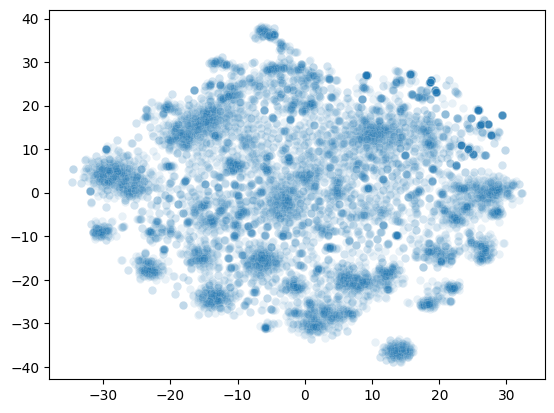

In [ ]:
sns.scatterplot(x=tf_idf_tsne_vis_emb[:, 0],
                y=tf_idf_tsne_vis_emb[:, 1],
                alpha=.1)

#KMeans + TF-IDF

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

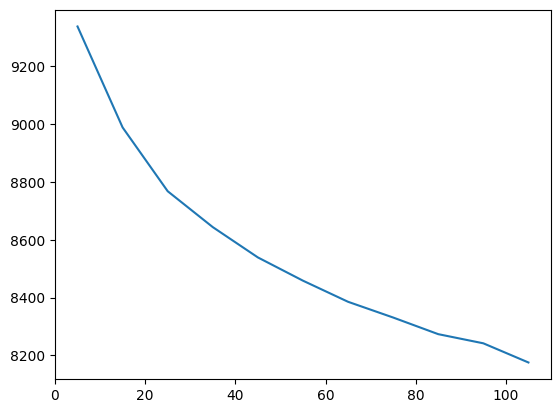

In [ ]:
sse = []
sil_scor = []
list_k = [i for i in range(5, 105+1, 10)]
for k in list_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tf_idf_emb)
    sse.append(kmeans.inertia_)
    tf_idf_kmeans_clusters = kmeans.predict(tf_idf_emb)

sns.lineplot(x=list_k, y=sse)

Явно оптимальное количество кластеров не просматривается, но перспективнее всего выглядит перегиб между 20-25 кластерами:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

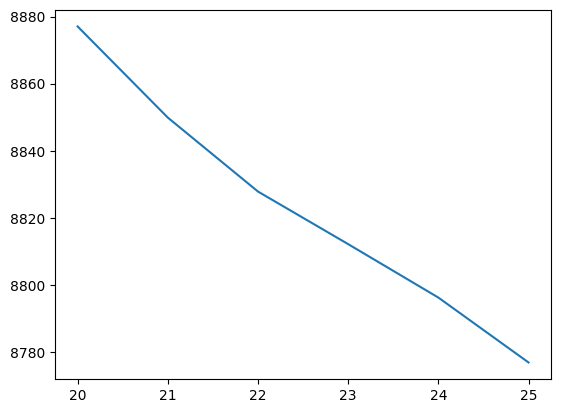

In [ ]:
sse = []
sil_scor = []
list_k = [i for i in range(20, 25+1)]
for k in list_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tf_idf_emb)
    sse.append(kmeans.inertia_)
    tf_idf_kmeans_clusters = kmeans.predict(tf_idf_emb)

sns.lineplot(x=list_k, y=sse)

Посмотрим на результат:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


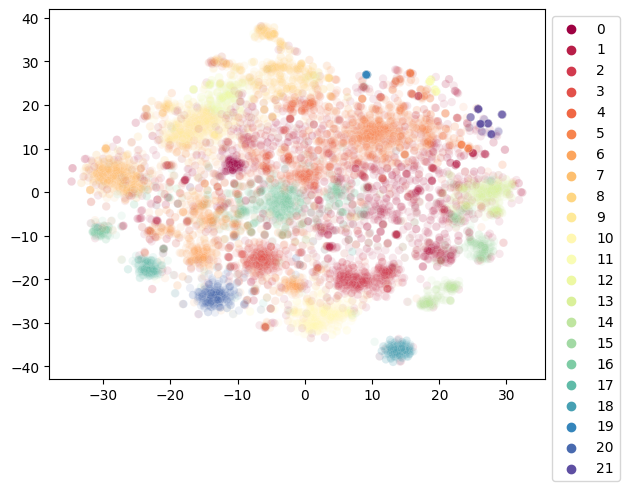

In [ ]:
kmeans = KMeans(n_clusters=22, random_state=1)
tf_idf_kmeans_clusters = kmeans.fit_predict(tf_idf_emb)
ax = sns.scatterplot(x=tf_idf_tsne_vis_emb[:, 0],
                y=tf_idf_tsne_vis_emb[:, 1],
                alpha=.1, hue=tf_idf_kmeans_clusters,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Сопоставим тексты и кластеры:

In [ ]:
tf_idf_kmeans = pd.DataFrame({'text': sample_for_tf_idf,
                              'cluster': tf_idf_kmeans_clusters})

tf_idf_kmeans['name'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_kmeans.index)].name
tf_idf_kmeans['key_skills'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_kmeans.index)].key_skills

tf_idf_kmeans

,text,cluster,name,key_skills
17469,"[искать, активный, позитивный, инициативный, ч...",5,менеджер интернет магазина,активные продажи crm прямые продажи клиентоори...
311264,"[международный, it, лидер, свой, сегмент, связ...",5,менеджер по продажам инженерное по,ведение переговоров активные продажи заключени...
24559,"[большой, активно, развиваться, создание, един...",10,frontend разработчик react,javascript css rest api html react redux
185615,"[будущий, выполнение, план, vas, услуга, поиск...",5,менеджер по продажам,проведение презентаций ориентация на результат...
289448,"[структурный, подразделение, внедрение, иннова...",4,руководитель проекта по внедрению it технологий,it
...,...,...,...,...
28747,"[отрисовка, дизайн, макет, страница, инфографи...",15,веб дизайнер,adobe illustrator adobe photoshop css html ux ...
352642,"[приглашать, монтажник, новый, участок, строит...",8,монтажник жбк гатчина,строительство
366357,"[продвигать, клип, сервис, короткий, развлекат...",1,креативный продюсер в команду клипов,креативность грамотность
167964,"[группа, внедрение, аскуэ, бытовой, потребител...",4,менеджер проекта,управление проектами договоры подряда составле...


Посмотрим на кластеры:

In [ ]:
tf_idf_kmeans.cluster.value_counts()

1     1780
5      958
6      839
16     727
4      687
8      641
9      532
7      488
10     447
2      411
13     378
3      335
20     285
12     263
15     228
14     227
18     198
17     177
21     136
0      129
11      91
19      43
Name: cluster, dtype: int64

In [ ]:
for cluster in tf_idf_kmeans.cluster.value_counts().index:
  print(f'cluster: {cluster}')
  print('cluster lengh: ', tf_idf_kmeans[tf_idf_kmeans.cluster == cluster]\
        .cluster.value_counts().values[0], '\n')
  print(tf_idf_kmeans[tf_idf_kmeans.cluster == cluster].sample(10).name, '\n')

cluster: 1
cluster lengh:  1780 

245372                    преподаватель курса с ут удаленно
31876                                  продавец консультант
421535              старший специалист по развитию франшизы
543853                       руководитель отдела маркетинга
444240     администратор эквайринга системный администратор
395308                     специалист технической поддержки
363565           архитектор решений solution architect в вв
387435                                 senior ux researcher
442393                                       level designer
352932    преподаватель по информатике и вычислительной ...
Name: name, dtype: object 

cluster: 5
cluster lengh:  958 

281092                         специалист отдела маркетинга
90880                               менеджер по продажам it
213116                       менеджер по работе с клиентами
114725                    сервис менеджер по работе глонасс
220777                       удаленный оператор консультант
48104

Анализ:

1.   Видно, что первый кластер, получившийся наиболее крупным, включает в себя разные профессии, то есть его нельзя назвать полезным;
2.   Пятый кластер включает различных менеджеров, прежде всего менеджеров по продажам;
3. Шестой кластер также включает достаточные разные профессии, но они все относятся к it;
4. В шеснадцатый кластер входят различные аналитики;
5. Четвертый кластер включает различных менеджеров/руководителей в it;
6. Восьмой кластер в основном включает различных промышленных рабочих;
7. Девятый кластер - системные администраторы;
8. Седьмой кластер - программисты, в основном на C;
9. Десятый кластер - frontend разработчики, часто на JS;
10. Второй кластер - PHP разработчики;
11. Тренадцатый кластер - SMM, интернет маркетологи и тд;
12. Третий кластер - тестировщики;
13. Двадцатый кластер - JAVA разработчики;
14. Двенадцатый клстер получился достаточно неопределенным. Часто там различные мастера/инженеры;
15. Пятнадцатый кластер - UX/UI и дизайнеры;
16. Четырнадцатый кластер - IOS разработчики;
17. Восемнадцатый кластер - вакансии на английском;
18. Семнадцатый кластер - NET разработчики;
19. Двадцать первый кластер - специалисты службы поддержки;
20. Кластер ноль - специалисты по ИБ;
21. Кластер одинадцать - продавцы-консультанты;
22. Девятнадцатый кластер - продажники и установщики спутникового тв.



#SpectralClustering + TF-IDF

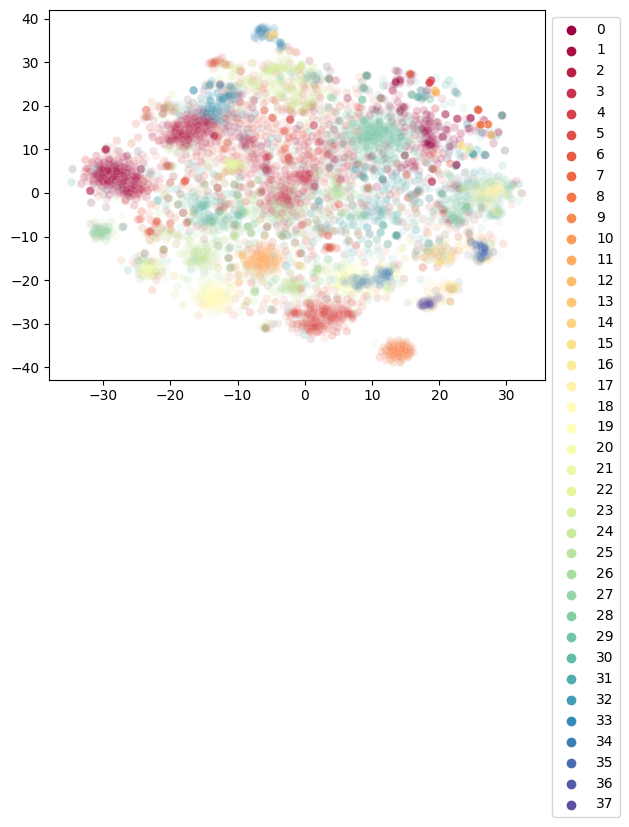

In [ ]:
spectral_clust = SpectralClustering(n_clusters=38, n_components=24)

tf_idf_spectral_clust_clusters = spectral_clust.fit_predict(tf_idf_emb)
ax = sns.scatterplot(x=tf_idf_tsne_vis_emb[:, 0],
                y=tf_idf_tsne_vis_emb[:, 1],
                alpha=.1, hue=tf_idf_spectral_clust_clusters,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
tf_idf_spectral_clust = pd.DataFrame({'text': sample_for_tf_idf,
                              'cluster': tf_idf_spectral_clust_clusters})

tf_idf_spectral_clust['name'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_spectral_clust.index)].name
tf_idf_spectral_clust['key_skills'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_spectral_clust.index)].key_skills

tf_idf_spectral_clust

,text,cluster,name,key_skills
17469,"[искать, активный, позитивный, инициативный, ч...",0,менеджер интернет магазина,активные продажи crm прямые продажи клиентоори...
311264,"[международный, it, лидер, свой, сегмент, связ...",29,менеджер по продажам инженерное по,ведение переговоров активные продажи заключени...
24559,"[большой, активно, развиваться, создание, един...",5,frontend разработчик react,javascript css rest api html react redux
185615,"[будущий, выполнение, план, vas, услуга, поиск...",29,менеджер по продажам,проведение презентаций ориентация на результат...
289448,"[структурный, подразделение, внедрение, иннова...",3,руководитель проекта по внедрению it технологий,it
...,...,...,...,...
28747,"[отрисовка, дизайн, макет, страница, инфографи...",35,веб дизайнер,adobe illustrator adobe photoshop css html ux ...
352642,"[приглашать, монтажник, новый, участок, строит...",23,монтажник жбк гатчина,строительство
366357,"[продвигать, клип, сервис, короткий, развлекат...",31,креативный продюсер в команду клипов,креативность грамотность
167964,"[группа, внедрение, аскуэ, бытовой, потребител...",3,менеджер проекта,управление проектами договоры подряда составле...


In [ ]:
for cluster in tf_idf_spectral_clust.cluster.value_counts().index:
  print(f'cluster: {cluster}')
  print('cluster lengh: ', tf_idf_spectral_clust[tf_idf_spectral_clust.cluster == cluster]\
        .cluster.value_counts().values[0], '\n')
  print(tf_idf_spectral_clust[tf_idf_spectral_clust.cluster == cluster].sample(10).name, '\n')

cluster: 6
cluster lengh:  1156 

451057                             smm специалист
89180               программист с документооборот
485927                                    инженер
121328                    системный администратор
255764         менеджер систем эффективных продаж
319594               оператор розничного склада с
527958                         инженер mes систем
179043    инженер информационного сопровождения с
549817                  консультант программист c
118270                         программист python
Name: name, dtype: object 

cluster: 31
cluster lengh:  798 

292630                              php developer marketing
271599                              middle business analyst
118832                  product manager app санкт петербург
123006                            technical account manager
152614                                оператор ввода данных
345636                            head of account managment
366126                                   ста

Кажется, что большинство классов описываются достаточно красноречиво, кроме 6, самого крупного и 31. Они, как и в случае с KMeans, собирает в себя различные выбросы.

Также, относительно алгоритма можно сказать, что визуально лучший вариант кластеризации включает в себя бОльшее количество кластеров, чем по "правилу локтя" было определено в KMeans, хотя некоторые кластеры становятся уже очень узкоспециализированными. Например, 13, 36, 20, потому что они включают в себя часто повторяющиеся достаточно уникальные для этой конкретной группы слова.

Если алогритму указать такое же количество кластеров, как для KMeans, то в результате "общие" кластера будут горазбо больше.

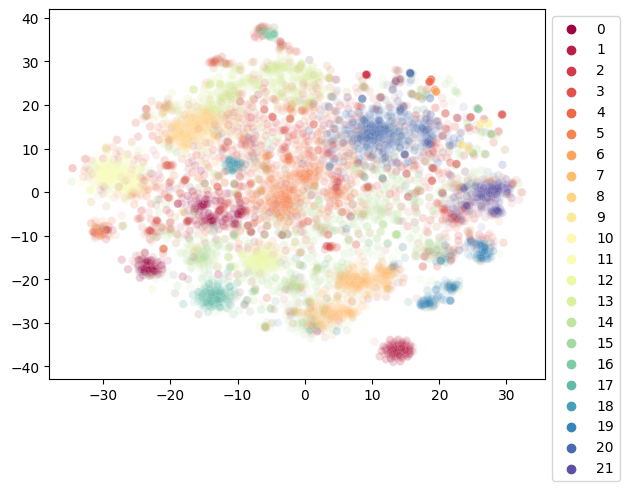

In [ ]:
new_spectral_clust = SpectralClustering(n_clusters=22, n_components=20)

tf_idf_new_spectral_clust_clusters = new_spectral_clust.fit_predict(tf_idf_emb)
ax = sns.scatterplot(x=tf_idf_tsne_vis_emb[:, 0],
                y=tf_idf_tsne_vis_emb[:, 1],
                alpha=.1, hue=tf_idf_new_spectral_clust_clusters,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
tf_idf_new_spectral_clust = pd.DataFrame({'text': sample_for_tf_idf,
                              'cluster': tf_idf_new_spectral_clust_clusters})

tf_idf_new_spectral_clust['name'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_new_spectral_clust.index)].name
tf_idf_new_spectral_clust['key_skills'] = augumented_data[augumented_data.index\
                                        .isin(tf_idf_new_spectral_clust.index)].key_skills

In [ ]:
for cluster in tf_idf_new_spectral_clust.cluster.value_counts().index:
  print(f'cluster: {cluster}')
  print('cluster lengh: ', tf_idf_new_spectral_clust[tf_idf_new_spectral_clust.cluster == cluster]\
        .cluster.value_counts().values[0], '\n')
  print(tf_idf_new_spectral_clust[tf_idf_new_spectral_clust.cluster == cluster].sample(10).name, '\n')

cluster: 2
cluster lengh:  2690 

111679                            golang разработчик senior
301111                             art manager арт менеджер
206954                                          team leader
20405                                            web мастер
444968      nlp разработчик центр искусственного интеллекта
586771    менеджер по сопровождению клиентов специалист ...
196222                            нарративный гейм дизайнер
421348    middle senior php to go developer направление ...
70149     старший гейм дизайнер american dad apocalypse ...
164569                      старший гейм дизайнер экономика
Name: name, dtype: object 

cluster: 4
cluster lengh:  1489 

336555                    старший аналитик senior analyst
197501                               системный архитектор
184786      руководитель проектов автоматизации г воронеж
520378            руководитель направления data аналитики
279246    начальник отдела учета и приемки тмц в г алматы
467580        

# KMeans + эмбеденги из трансформера

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

<Axes: >

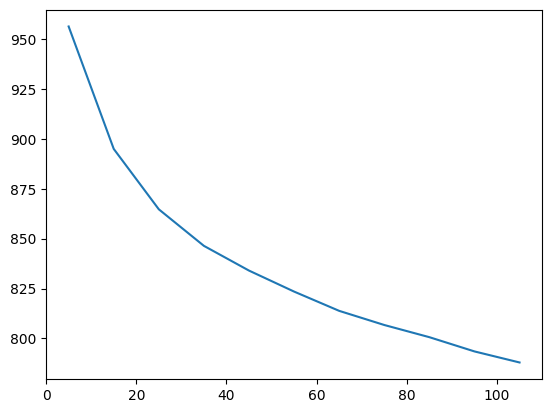

In [ ]:
sse = []
sil_scor = []
list_k = [i for i in range(5, 105+1, 10)]
for k in list_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(transformer_emb)
    sse.append(kmeans.inertia_)
    transformer_kmeans_clusters = kmeans.predict(transformer_emb)

sns.lineplot(x=list_k, y=sse)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

<Axes: >

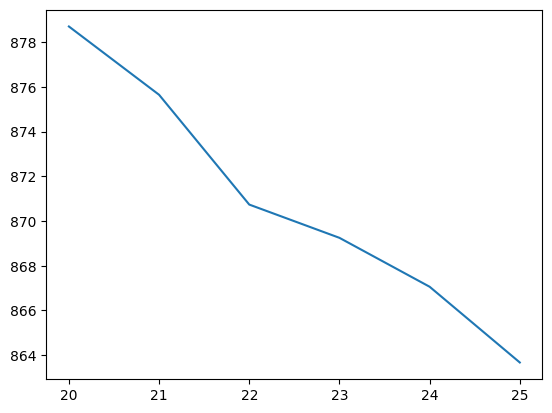

In [ ]:
sse = []
sil_scor = []
list_k = [i for i in range(20, 25+1, 1)]
for k in list_k:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(transformer_emb)
    sse.append(kmeans.inertia_)
    transformer_kmeans_clusters = kmeans.predict(transformer_emb)

sns.lineplot(x=list_k, y=sse)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


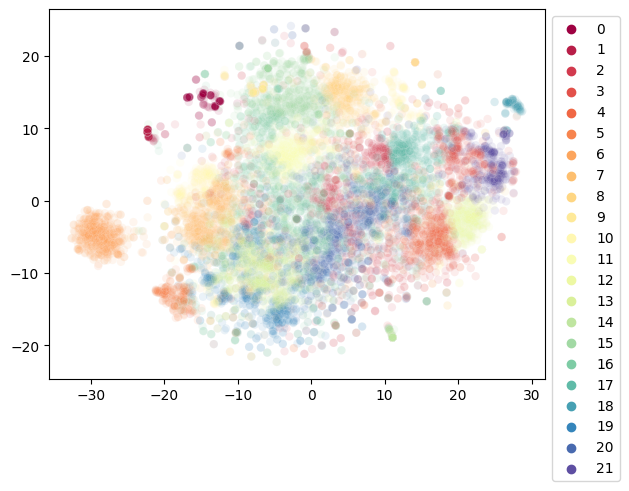

In [ ]:
kmeans = KMeans(n_clusters=22, random_state=2)
transformer_kmeans_clusters = kmeans.fit_predict(transformer_emb)
ax = sns.scatterplot(x=sample_tsne_vis_transformer_emb[:, 0],
                y=sample_tsne_vis_transformer_emb[:, 1],
                alpha=.1, hue=transformer_kmeans_clusters,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
transformer_kmeans = pd.DataFrame({'text': sample_for_transformer,
                              'cluster': transformer_kmeans_clusters})

transformer_kmeans['name'] = augumented_data[augumented_data.index\
                                        .isin(transformer_kmeans.index)].name
transformer_kmeans['key_skills'] = augumented_data[augumented_data.index\
                                        .isin(transformer_kmeans.index)].key_skills

transformer_kmeans

,text,cluster,name,key_skills
530171,query: иннотех это группа компаний втб ведомая...,13,senior devops engineer,автоматизация разработка нового продукта docke...
549331,query: компания традиции стабильности поставля...,11,ведущий контент менеджер,администрирование сайтов грамотность html ms o...
121413,query: обязанности разработка backend микросер...,10,разработчик c junior,asp net c html css ms sql jquery java субд
441851,query: в связи с расширением в компании открыт...,2,инженер второй линии технической поддержки,sql
538434,query: quantori is a new company with a long h...,6,devops aws architect,aws gcp docker kubernetes
...,...,...,...,...
131524,query: каждый день миллионы пользователей нахо...,0,специалист службы поддержки пользователей,английский язык ms powerpoint грамотная речь о...
25961,query: мы занимается всеми видами системной ин...,4,ведущий инженер отдела аварийно восстановитель...,cisco juniper
206780,query: команда по развитию электронных каналов...,16,бизнес аналитик по развитию продуктов и процес...,ms excel ms visio uml bpmn agile project manag...
288405,query: международная компания perfect art лет ...,19,qa engineer,atlassian jira java sql atlassian confluence m...


In [ ]:
for cluster in transformer_kmeans.cluster.value_counts().index:
  print(f'cluster: {cluster}')
  print('cluster lengh: ', transformer_kmeans[transformer_kmeans.cluster == cluster]\
        .cluster.value_counts().values[0], '\n')
  print(transformer_kmeans[transformer_kmeans.cluster == cluster].sample(10).name, '\n')

cluster: 16
cluster lengh:  963 

87602                дежурный инженер технической поддержки
576853                   менеджер по продажам sales manager
349018    customer care инженер системы управления выезд...
303792           marketing manager market researcher remote
132234    агент службы поддержки со знанием украинского ...
150235                                 системный архитектор
486265                                       smm маркетолог
208311       скрам мастер scrum master in a startup company
579363                         business development manager
475587                               senior project manager
Name: name, dtype: object 

cluster: 13
cluster lengh:  825 

269505                             инженер по сопровождению
513382                                  ведущий программист
142290    team lead senior java developer bigdata hadoop...
115589               middle senior test automation engineer
425815                                fullstack team leader
4730

Анализ:

1. 16 кластер самый большой, но там не просматривается конкретной профессии;
2. 13 кластер включает it специальности, но доминирующую выявить сложно;
3. 20 кластер - в основном аналитики + другие it специальности;
4. 17 кластер - it специалисты;
5. 15 кластер - специалисты по работе с клиентами, менеджеры по продажам;
6. 19 кластер - разработчики, data scientist-ы;
7. 7 кластер - full-stack разработчики;
8. 2 кластер - it специалисты;
9. 6 кластер - вакансии на английском;
10. 3 кластер - инженеры и рабочие;
11. 8 кластер - различные специальности;
12. 4 кластер - техподдержка и it специалисты;
13. 11 кластер - smm и маркетенг;
14. 10 кластер - front-end разработчики;
15. 12 кластер - системные администраторы;
16. 21 кластер - монтажники;
17. 5 кластер - дизайнеры, арт-директоры, продюсеры;
18. 0 кластер - похоже на вакансии Яндекса;
19. 9 кластер - продажники, операторы колл-центра;
20. 18 кластер - оператор станков;
21. 1 кластер - репетиторы математики;
22. 14 кластер - продавци и установщики спутникового тв.

В целом кластеры достаточно размытые, почти во всех крупных кластерах связанных с it намешано много разных специальностей.

#SpectralClustering + эмбеденги из трансформера

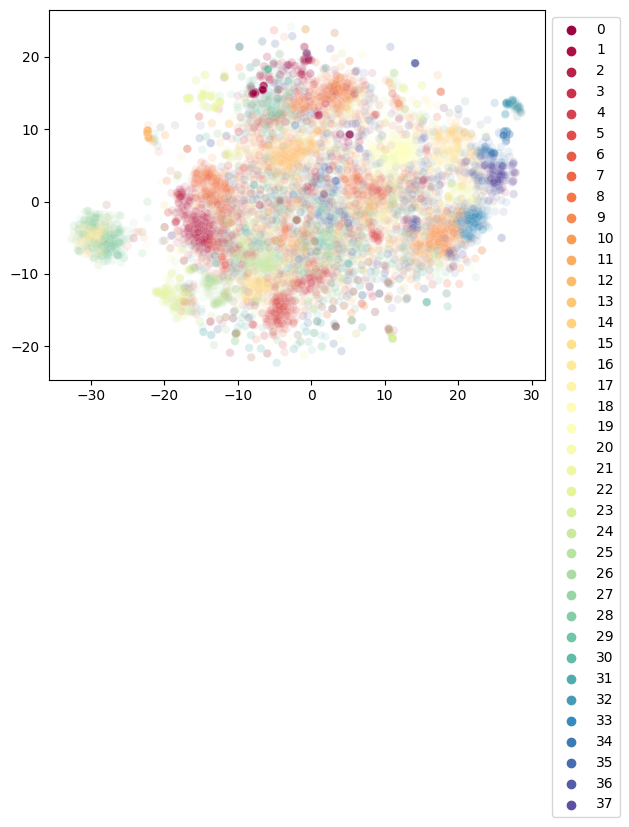

In [ ]:
spectral_clust = SpectralClustering(n_clusters=38, n_components=24)

tranformer_spectral_clust_clusters = spectral_clust.fit_predict(transformer_emb)
ax = sns.scatterplot(x=sample_tsne_vis_transformer_emb[:, 0],
                y=sample_tsne_vis_transformer_emb[:, 1],
                alpha=.1, hue=tranformer_spectral_clust_clusters,
                palette="Spectral",
                legend='full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
tranformer_spectral_clust = pd.DataFrame({'text': sample_for_transformer,
                              'cluster': tranformer_spectral_clust_clusters})

tranformer_spectral_clust['name'] = augumented_data[augumented_data.index\
                                        .isin(tranformer_spectral_clust.index)].name
tranformer_spectral_clust['key_skills'] = augumented_data[augumented_data.index\
                                        .isin(tranformer_spectral_clust.index)].key_skills

tranformer_spectral_clust

,text,cluster,name,key_skills
530171,query: иннотех это группа компаний втб ведомая...,4,senior devops engineer,автоматизация разработка нового продукта docke...
549331,query: компания традиции стабильности поставля...,35,ведущий контент менеджер,администрирование сайтов грамотность html ms o...
121413,query: обязанности разработка backend микросер...,8,разработчик c junior,asp net c html css ms sql jquery java субд
441851,query: в связи с расширением в компании открыт...,18,инженер второй линии технической поддержки,sql
538434,query: quantori is a new company with a long h...,16,devops aws architect,aws gcp docker kubernetes
...,...,...,...,...
131524,query: каждый день миллионы пользователей нахо...,21,специалист службы поддержки пользователей,английский язык ms powerpoint грамотная речь о...
25961,query: мы занимается всеми видами системной ин...,10,ведущий инженер отдела аварийно восстановитель...,cisco juniper
206780,query: команда по развитию электронных каналов...,4,бизнес аналитик по развитию продуктов и процес...,ms excel ms visio uml bpmn agile project manag...
288405,query: международная компания perfect art лет ...,5,qa engineer,atlassian jira java sql atlassian confluence m...


In [ ]:
for cluster in tranformer_spectral_clust.cluster.value_counts().index:
  print(f'cluster: {cluster}')
  print('cluster lengh: ', tranformer_spectral_clust[tranformer_spectral_clust.cluster == cluster]\
        .cluster.value_counts().values[0], '\n')
  print(tranformer_spectral_clust[tranformer_spectral_clust.cluster == cluster].sample(10).name, '\n')

cluster: 13
cluster lengh:  425 

183001                                  интернет маркетолог
470243                             аналитик каналов трафика
391806          специалист по видео контенту youtube канала
488361                специалист по таргетированной рекламе
216765                помощник seo специалиста link builder
469981                             руководитель it проектов
123008                          специалист по анализу рынка
230657                                       seo копирайтер
145868    системный администратор системный инженер битрикс
281951                          специалист по анализу рынка
Name: name, dtype: object 

cluster: 10
cluster lengh:  415 

517936                        инженер технической поддержки
222976                              системный администратор
551013       инженер специалист информационной безопасности
273776                      системный cетевой администратор
465882                                      инженер ip mpls
5545

Анализ:

1. 13 кластер - работа в интернете;
2. 10 - системные администраторы;
3. 26 - it специалисты;
4. 19 - программисты на С;
5. 2 - front-end разработчики;
6. 6 - it специалисты;
7. 9 - продажники и руквоводители продажников;
8. 11 - it специалисты;
9. 24 - python разработчики;
10. 35 - it специалисты;
11. 30 - аналитики/менеджеры;
12. 8 - full-stack разработчики;
13. 31 - разработчики;
14. 5 - тестировщики;
15. 18 - back-end разработчики;
16. 15 - java разработчики;
17. 7 - аналитики;
18. 22 - дизайнеры, монтажеры, сценаристы и тд;
19. 17 - руководители/менеджеры проектов;
20. 20 - мастера/рабочие;
21. 37 - мастера/рабочие;
22. 25 - android разработчики;
23. 4 - аналитики;
24. 29 - телефонные продажники;
25. 14 - промышленные рабочие;
26. 3 - менеджеры;
27. 1 - специалисты по работе с клиентами, сильно разбавленные другими специальностями;
28. 28 - вакансии на английском;
29. 33 - системные администраторы;
30. 36 - разные специальности;
31. 16 - разработчики, английские вакансии;
32. 34 - монтажники;
33. 21 - техподдержка;
34. 0 - продавцы-консультанты;
35. 27 - разработчики, английские вакансии;
36. 32 - операторы станков;
37. 12 - менеджеры продаж уроков математики;
38. 23 - продажники и установщики спутникового тв.

В целом есть много кластеров с размытыми данными, некоторые логически единые кластеры разбиты на два/три. Но в целом, кажется, что этот алгоритм на трансформерных эмбедингах сработал лучше.